# Baseline Model Experiment 

This notebook contains a baseline model experiment with a simple Artificial Neural Network (ANN) using [FastAI Tabular Learner](https://docs.fast.ai/tabular.learner.html). We begin experiments with this simple model on the premise that - when taking into account the level of effort - clever feature engineering typically outperforms employing alternative model types (such as using LSTMs). 

A few items about the experiment: 

- We train for `D` days (periods) and predict on the next day in order to train the model. After each complete period, the model is retrained on the new data (either from scratch or with transfter learning). We model the experiment this way to coincide with how a model would be used in practice and to account for the fast that the most recent data has an outsized influence on model performance. 
- We identify and utilize periods of observations for model training and testing that are greater than some threshold `period_size`. Deep neural networks cannot be trained with missing data. 
- Related to the above, it would be an inappropriate training strategy to simply concatenate the periods together during the training process - the value(s) at the end of a period does not help predict the values at the beginning of the next period. As such, we will need to retrain the model for each subsequent day in the training set using transfer learning. The same testing set is used throughout the model training process. 
- An appropriate learning rate is determined using an automated learning rate finder. 
- The model is trained using an early stopping criterion that is intened to ovoid model overfitting. 
- A selection of possible model architectures for the ANN (nodes in the layers, drop out rates, etc). is available for the experiments. 

## Imports 

In [1]:
import sys; sys.executable

'/home/vconstan/.conda/envs/tsunami/bin/python'

In [2]:
from fastai.tabular import *
from fastai.metrics import *
from fastai import torch_core
from fastai.callbacks import *
from fastai.callbacks.mem import PeakMemMetric
from fastai.utils.mod_display import *

import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from PyNomaly import loop
import random
from sklearn.preprocessing import minmax_scale
import seaborn as sns
from scipy import spatial, stats
from src import data
import time
import torch
from typing import Union
from tqdm.notebook import tqdm

Ensure that CUDA is available for modeling. 

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

3

One useful command for monitoring GPU utilization is one from `nvidia-smi`:

```bash
nvidia-smi -q -g 0 -d UTILIZATION -l
```

Another handy tool is `gpustat`: 

```bash
gpustat -cp -i 1
```

In [5]:
# TODO: we may want to explore adding some of this functionality for logging etc. 
# https://stackoverflow.com/questions/58216000/get-total-amount-of-free-gpu-memory-and-available-using-pytorch

## Experiment Parameters

First, we can specify and select a variety of architectures for the model. More specifically, the below architectures are used by FastAI's tabular learner. 

In [6]:
architectures = {
    1: {
        "layers": [10, 500, 1000, 2500, 25000, 2500, 1000, 500, 10],
        "ps": [0.0, 0.1, 0.2, 0.2, 0.25, 0.2, 0.2, 0.1, 0.0]
    },
    2: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.5, 0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.025, 0.0]
    },
    3: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.0, 0.025, 0.05, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5]
    },
    4: {
        "layers": [50000, 5000, 1000, 500, 25, 1],
        "ps": [0.2, 0.15, 0.1, 0.05, 0.025, 0.]
    },
    5: {
        "layers": [50000, 7500, 2500, 1000, 250, 80, 25, 1],
        "ps": [0.25, 0.2, 0.15, 0.1, 0.05, 0.025, 0.01, 0]
    },
    6: {
        "layers": [1000, 250, 50, 1],
        "ps": [0.2, 0.1, 0.025, 0.]
    },
    7: {
        "layers": [3, 3],
        "ps": [0.1, 0.0]
    },
    8: {
        "layers": [10, 10, 10, 10, 10, 10],
        "ps": [0.1, 0.1, 0.1, 0.1, 0.05, 0.0]
    }
}

Other experimental parameters are set below, such as which data to use in the experiment, which satellite to model, and other model specifications. A single model is applied to each satellite, so the below would be repeated over more than one satellite to conduct a thorough experiment. 

In [7]:
class Model:
    # TODO: somehow add the cuda device in this class or Experiments class
    
    ## Work in progress
    @staticmethod
    def make_data_bunch(
        df_train: pd.DataFrame, 
        df_test: pd.DataFrame, 
        df_valid: pd.DataFrame, 
        features: list, 
        dependent: str, 
        cuda_device: torch.device,
        include_catvars: bool = False, 
        catvars: list = [], 
        batch_size: int = 256
    ) -> dict:
        """
        Creates a TabularDataBunch to feed as an input 
        into the learner. 
        """

        valid_start_index = df_train.shape[0] + 1
        valid_end_index = df_train.shape[0] + df_test.shape[0]

        df_train_validation = pd.concat([df_train, df_test])

        # create the data bunch
        if include_catvars:
            data = TabularDataBunch.from_df(
                "models", 
                df_train_validation[features + [dependent]], 
                dependent, 
                valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
    #             test_df=df_test, 
                procs=[Categorify],
                bs=batch_size, # batch size
                cat_names=catvars,
                device=cuda_device,
                num_workers=0
            )
        else:
            data = TabularDataBunch.from_df(
                "models", 
                df_train_validation[features + [dependent]], 
                dependent, 
                valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
    #             test_df=df_test, 
                procs=None, # disable any automatic preprocessing
                bs=batch_size, # batch size
                device=cuda_device,
                num_workers=0
            )

        return {
            "databunch": data, 
            "train": df_train, 
            "test": df_test, 
            "valid": df_valid
        }
    
    @staticmethod
    def find_appropriate_lr(model: Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
        
        """
        We utilize an [automatic learning rate finder](https://forums.fast.ai/t/automated-learning-rate-suggester/44199/8) to 
        determine the ideal learning rate automatically. While this approach does not always guarantee that the perfect 
        learning rate is found, in practice we have found the approach to work well and has been quite stable.
        """
        
        #Run the Learning Rate Finder
        model.lr_find(
            end_lr=2.,
            stop_div=False # continues through all LRs as opposed to auto stopping
        )

        #Get loss values and their corresponding gradients, and get lr values
        losses = np.array(model.recorder.losses)
        assert(lr_diff < len(losses))
        loss_grad = np.gradient(losses)
        lrs = model.recorder.lrs

        #Search for index in gradients where loss is lowest before the loss spike
        #Initialize right and left idx using the lr_diff as a spacing unit
        #Set the local min lr as -1 to signify if threshold is too low
        local_min_lr = None
        r_idx = -1
        l_idx = r_idx - lr_diff
        while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
            local_min_lr = lrs[l_idx]
            r_idx -= 1
            l_idx -= 1

        lr_to_use = local_min_lr * adjust_value

        if plot:
            # plots the gradients of the losses in respect to the learning rate change
            plt.plot(loss_grad)
            plt.plot(len(losses)+l_idx, loss_grad[l_idx], markersize=10, marker='o', color='red')
            plt.ylabel("Loss")
            plt.xlabel("Index of LRs")
            plt.show()

            plt.plot(np.log10(lrs), losses)
            plt.ylabel("Loss")
            plt.xlabel("Log 10 Transform of Learning Rate")
            loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
            plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
            plt.show()

        return lr_to_use
    
    @staticmethod
    def predict_values(dataframe: pd.DataFrame, learner: tabular_learner, dependent: str, frac: float = 1.0) -> pd.DataFrame:
    
        """
        Using the passed learner, predicts the appropriate value given the input data 
        and generates errors for analysis. 
        
        Optional frac parameter allows user to specify whether they would like to predict 
        over the entirety of the dataframe or over a smaller subset of data. 
        """

        # get a sample of the dataset 
        dataframe_pred = dataframe.copy()
        n_obs = int(dataframe_pred.shape[0] * frac)
        idx = random.sample(range(0, dataframe_pred.shape[0]), n_obs)
        dataframe_pred = dataframe_pred.iloc[idx, :]

        # get the predictions
        predictions = []
        print('Generating predictions and errors...')
        for idx, row in tqdm(dataframe_pred.iterrows(), total=dataframe_pred.shape[0]):        
            predictions.append(learner.predict(row)[1].numpy()[0])


        dataframe_pred["predicted"] = predictions
        dataframe_pred['error'] = dataframe_pred['predicted'] - dataframe_pred[dependent]
        dataframe_pred['absolute_error'] = np.abs(dataframe_pred['error'])
        dataframe_pred["timestamp"] = dataframe_pred.index

        return dataframe_pred
    
    # TODO: def classify 
    # this would use our error (residual) handling approach of choice to classify anomalies 
    # later assessed by the metrics class, which is applied over multiple classifications 
    
    

In [8]:
class Data:
    
    @staticmethod
    def get_periods(dataframe: pd.DataFrame) -> list: 
        
        """
        These periods are defined by consecutive empty (NaN) values in the dataframe. 
        The data is only available for the satellite as it passes close to the ground 
        station on each day. We could train the data in a similar way, ensuring our 
        approach is compatible with the constraints in the operating environment. 
        """

        # handle missing values and "chunk" the data for training and testing 
        events = np.split(dataframe, np.where(np.isnan(dataframe))[0])

        # removing NaN entries
        events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]

        # removing empty DataFrames
        events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

        return events
    
    @staticmethod
    def rescale_periods(events: list, feature_range: tuple = (-1, 1)) -> list: 
        """
        Rescales the values according to the specified feature range, default (-1, 1). 
        Reach period (typically a single day) is rescaled independently, mimicking the 
        proposed implementation of the model in practice (where it would be retrained 
        each day during the off-line period for the satellite and ground station). 
        Returns a list of normalized data, one entry for each period. 
        """
    
        normalized_events = list()
        for ev in events: 

            # for each column in the data, rescale -1 to 1 
            col_data = list()
            for col in ev.columns.values:

                normalized_data = minmax_scale(
                            ev[col].dropna(), 
                            feature_range=feature_range
                        )
                col_data.append(normalized_data)

            df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
            df_period["timestamp"] = ev[col].index
            df_period.index = df_period["timestamp"]
            df_period = df_period.drop(columns=["timestamp"])

            # convert to seconds of the day for later annotation 
            df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

            normalized_events.append(df_period)
            
        return normalized_events
    
    @staticmethod
    def allocate_periods(periods: list, index_earthquake: int) -> dict:
        """
        Based on which period is specified as containing the anomaly to be 
        detected, creates a training, testing, and validation set that can 
        be used to assess the approach and later obtain quantitative 
        performance metrics. The training set contains data that is pre-anomaly,
        with model training being guided by the single-period test set (the period 
        before the period with the anomaly). The validation set contains the period 
        of the anomaly. Any periods after the anomaly period are currenly not used 
        as part of the experimental process. 
        """
    
        data = dict()

        data["valid"] = periods[index_earthquake]
        data["test"] = periods[index_earthquake - 1]
        data["train"] = periods[0:index_earthquake - 1]

        return data

    
    
    

In [9]:
class Experiment(object):
    # TODO: need someway to establish the cuda device and pass it onto Modeling object
    #       Maybe tie the cuda device to the modeling object? or tie it to experiment

    def __init__(self,
                 independent_variables: list,
                 satellites: list,
                 ground_stations: list,
                 model: 'tabular_learner',
                 year: int = 2012,
                 location: str = "hawaii",
                 elevation_filter: Union[int, None] = None,
                 time_aggregation: str = "1min",
                 batch_normalization: bool = True, weight_decay: float = 0.1,
                 models_save_directory: str = "", models_root_name: str = "model-latest",
                 max_epochs: int = 500, cuda_device: int = 0):

        # experiment setup
        self.year = year
        self.location = location
        # TODO: below path will need rework when placed in src/modeling.py
        self.data_paths = Path('../data/' + self.location + '/' + str(self.year))
        self.days = [str(f).split("/")[-1] for f in self.data_paths.iterdir() if f.is_dir()]
        self.independent_variables = independent_variables
        self.satellites = satellites
        self.ground_stations = ground_stations
        self.elevation_filter = elevation_filter
        self.time_aggregation = time_aggregation
        self.batch_normalization = batch_normalization
        self.weight_decay = weight_decay
        self.models_save_directory = models_save_directory
        self.models_root_name = models_root_name
        self.max_epochs = max_epochs
        
         # set the cuda device for experiment
        torch.cuda.set_device(cuda_device)
        self.cuda_device = torch.device("cuda:" + str(cuda_device)) #pass this onto model?
       
        
       
        self.model = model
        self.dataframes = dict()  # stores individual dataframes read from csv
        
        # TODO: experiment results
        
        # This was just for me to know if the cuda device is set up correctly
        print("For this Experiment:")
        print("Using following CUDA device:", torch.cuda.get_device_name(self.cuda_device))

        
        # experiment tracking - one entry per ground station and satellite combination 
        self.results = dict()
        
    def read_data(self) -> None:

        # TODO: below can be made into a function in another class called Data
        # read all of the data into a dictionary
        self.dataframes = dict()
        for d in self.days:
            print("\n--- " + str(d) + "---")

            # read in the data
            df = data.read_day(
                location=self.location,
                year=self.year,
                day_of_year=int(d)
            )
            self.dataframes[d] = {
                "dataframe": df,
            }
        
        # this dataframe will store all day dataframes by satellite and ground station combinations
        self.dataframes["all_days"] = dict()
            
    def merge_data(self) -> None:

        # TODO: much of the below can be made into a function in another class called Data
        # concatenate the dataframes loaded previously into one large dataframe
        df_all = pd.concat([self.dataframes[d]["dataframe"] for d in self.dataframes.keys() if d != "all_days"])

        # filter for the satellites and store the respective dataframes
        # NOTE: assumes len(self.satellites) >= len(self.ground_stations)
        pairs = itertools.product(self.satellites, self.ground_stations)

        for p in pairs:
            
            # get the data for the particular satellite 
            df_sat = df_all.filter(regex=p[1] + "__" + p[0], axis=1)
            
            # filter out cases where modeling cannot be effectively applied
            if df_sat.shape[0] <= 500:
                # continue skips the rest of this for loop 
                continue
            
            # apply the elevation filter 
            if self.elevation_filter is not None: 
                df_sat = df_sat[df_sat[p[1] + "__" + p[0] + "_ele"] > self.elevation_filter]
            
            # resample the data as specified in the experiment 
            # aggregate using the mean value NOTE that this is a strategy that can be changed
            # min, max, are other options
            # our data does not contain more than 1 value per second so it is not affected 
            # by this strategy, but step taken for safety 
            df_model = df_sat.dropna().resample(self.time_aggregation).mean()
            
            # TODO: this should arguably not be here and be abstacted into something else and then called here
            # some data transmission errors in model training data 
            # not in scope for this initial work, so we want to cleanse the training data a bit 
            # use local outlier detection approach (Local Outlier Probabilities, 2009) to do this 
            # PyNomaly python library used to use the LoOP approach 
            if p[0] == "G07":
                # period of identified errors in transmission 
                filter_index = df_model.index.to_series().between('2012-10-22', '2012-10-23 23:59:00')
                
                # create a subsetted dataframe to work with 
                df_model_outliers = df_model[filter_index].dropna()
                
                # fit the LoOP Outlier Detection approach 
                m = loop.LocalOutlierProbability(
                    df_model_outliers[
                        [
                            p[1] + "__" + p[0]
                        ]
                    ], 
                    extent=3, 
                    n_neighbors=500 # want to consider any and all neighbors so set to large size 
                ).fit()
                scores = m.local_outlier_probabilities
                df_model_outliers["outlier_scores"] = scores
                
                # the number of time periods before and after detected outlier to remove from the training data 
                # NOTE affected by specfied time_aggregation
                REMOVAL_WINDOW = 10 # number of minutes / points before and after 
                # cut-off value for identifiying an anomaly, which are > OUTLIER_THRESHOLD
                OUTLIER_THRESHOLD = 0.9 # on a scale [0, 1]
            
                # detect the outliers 
                outliers = df_model_outliers[df_model_outliers["outlier_scores"] > OUTLIER_THRESHOLD]
                
                # filter the training data 
                removal_windows = list()
                list_index = list(df_model.index.values)
                for idx in outliers.index.values:
                    idx_i = list_index.index(idx)
                    idx_range = [idx_i - REMOVAL_WINDOW, idx_i + REMOVAL_WINDOW]
                    removal_windows.append(idx_range)
                for rw in removal_windows:
                    df_model.iloc[rw[0]:rw[1], :] = None    

            # save
            self.dataframes["all_days"][p[1] + "__" + p[0]] = {"merged_dataframe": df_model}
            
            
    def prep_data(self) -> None: 
        """
        Data is split into periods where any NaN values are removed. 
        These are then normalized and made into a dataset that can be used 
        for modeling (training, test, and validation sets.)
        """
        
        # first, remove NaNs and split the data into periods 
        for station_sat in tqdm(self.dataframes["all_days"].keys()):
            events = Data.get_periods(self.dataframes["all_days"][station_sat]["merged_dataframe"])        
        
            # store the events for that 
            self.dataframes["all_days"][station_sat]["periods"] = events
        
            # then, rescale the values from -1 to 1 for each period to support the modeling 
            self.dataframes["all_days"][station_sat]["periods_normalized"] = Data.rescale_periods(events=events, feature_range=(-1,1))
            
            # allocate a training set, a testing set, and a validation set 
            self.dataframes["all_days"][station_sat]["periods_allocated"] = Data.allocate_periods(periods=self.dataframes["all_days"][station_sat]["periods_normalized"], index_earthquake=12)


    def train_models(self, input_layers: list, input_ps: list, batch_size: int) -> None:
        """
        For each ground station and satellite combination, train a model and 
        track the associated artifacts, output, and session information (such as the 
        training time). 
        """
    
        for station_sat in tqdm(self.dataframes["all_days"].keys()): 
            
            # create an entry in the results for later tracking 
            self.results[station_sat] = dict()
            
            # get the data to be modeled from the dictionary 
            data_to_model = self.dataframes["all_days"][station_sat]["periods_allocated"]
            
            # create the training, test, and valdiation sets to use in model training
            # we first need to assign the dependent variable based on the 
            df_train = pd.concat(data_to_model["train"])
            df_train[station_sat + "_target"] = df_train[station_sat]
            df_test = data_to_model["test"]
            df_test[station_sat + "_target"] = df_test[station_sat]
            df_valid = data_to_model["valid"]
            df_valid[station_sat + "_target"] = data_to_model["valid"][station_sat]
            
            #create the data bunch to be used in the modeling process
            data_bunch = Model.make_data_bunch(
                df_train,
                df_test,
                df_valid,
                [station_sat + var for var in self.independent_variables],
                station_sat + "_target", 
                cuda_device=self.cuda_device,
                include_catvars=False, 
                catvars=None, 
                batch_size=batch_size
            ) #TODO: might want to allow for dynamic control of Batch size (currently within experiment)
            
            # store the data bunch of the model for later use by predict functions 
            self.dataframes["all_days"][station_sat]["data_bunch"] = data_bunch
            
            #create the learner
            # TODO: might want to have a dynamic way of inputting the layers and the dropout parameter and connect
            #       it with the architecture dictionary
            lr = tabular_learner(
                data_bunch["databunch"], 
                layers=input_layers, 
                ps=input_ps,
                path=self.models_save_directory,
                metrics=[root_mean_squared_error], 
                callback_fns=[CSVLogger, PeakMemMetric],
                use_bn=self.batch_normalization,
                wd=self.weight_decay
            )
            
            # needed some way to include the cuda device
            # first, identify the ideal learning rate for this set of data 
            # TODO: plot only if experiment set to verboce 
            learn_rate = Model.find_appropriate_lr(model=lr, plot=False) 
            print("Learning Rate for {}:".format(station_sat), learn_rate)
            # since the learning rate can vary from model to model, let's track it 
            self.results[station_sat]["learning_rate"] = learn_rate
            
            # start a timer to track the training time 
            start = time.time()
        
            # train the model according to the specified architecture, paremeters, and 
            # identified learning rate 
            # TODO: right now that information is stored in the experiment class
            # but would be nicer if specified in the model class 
            # self.results can still include basic info about the model 
            # train the model 
            lr.fit_one_cycle(
                self.max_epochs,
                learn_rate,
                # the save model callback saves the model after each epoch 
                # the early stopping callback helps avoid overfitting and monitors the validation loss 
                callbacks=[
                    SaveModelCallback(
                        lr, 
                        every='epoch', 
                        monitor=['accuracy', 'root_mean_square_error']
                    ),
                    EarlyStoppingCallback(
                        lr,
                        monitor='valid_loss', #'valid_loss', 'root_mean_square_error'
                        min_delta=0.0001, # 0.0001
                        patience=15
                    ),
                    ShowGraph(
                        lr
                    )
                ]
            )
            
            # end a timer to track the training time and add to the results dict 
            finish = time.time()
            training_time = finish - start
            self.results[station_sat]["training_time"] = training_time
            
            # TODO: add a verbose option to experiment that outputs plots and 
            # more verbose information. 
            # TODO (diff from above): store the losses and metric plots for each model 
#             # loaded learners do not have a recorder
#             lr.recorder.plot_losses()
#             lr.recorder.plot_metrics()

    
            # store the root mean square error for this model 
            rmse = lr.recorder.metrics[-1][0].item()
            self.results[station_sat]["root_mean_square_error"] = rmse
            
            # TODO: store the training/testing and validation loss, num epochs also 

            # save the model for this specific station and satellite combination 
            # TODO: maybe store the model in the output dir, e.g. output/models
            save_location = self.models_save_directory + "/" + self.models_root_name + "-" + station_sat
            lr.save(save_location)
            lr.export(save_location + '-export.pkl')
            
            # store the trained learner in the experiment class for use in prediction and classification calls by the experiment class 
            self.results[station_sat]["trained_learner"] = lr 
            
    def predict_models() -> None: 
        """
        For each ground station and satellite combination, predicts the values for 
        sTEC d/dT on the day of the earthquake. Predictions and residual values are 
        stored for later visualization and analysis. 
        """
        
        # for each model 
        for station_sat in tqdm(self.dataframes["all_days"].keys()):
        
            # predict on the test data and store predictions
            df_test = predict_values(
                dataframe=data_bunch["test"], # TODO: currently using latest databunch from prev loop
                learner=lr, # TODO: currently using latest learner from prev loop
                dependent=DEP + "_target",
                frac=1.
            ).sort_index()

            # predict on the validation data (day of earthquake) and store predictions 
            df_valid = predict_values(
                dataframe=data_bunch["valid"], # TODO: currently using latest databunch from prev loop
                learner=lr, # TODO: currently using latest learner from prev loop
                dependent=DEP + "_target",
                frac=1.
            ).sort_index()
            
            # store the residuals in a directory for later analysis, further review for both test and validation sets 
            # if a directory doesn't exist for the model, create it 
            # TODO: below hard-coded path will need to be tweaked when pulling into src 
            output_path = '../output/models/experiments' + station_sat + "/residuals"
            if not os.path.exists(output_path):
                Path(output_path).mkdir(parents=True, exist_ok=True)

            # for the test set and valid set, store the prediction dataframes
            # these dataframes contain the residuals (errors) raw and absolute 
            df_test.to_csv(output + "/test.csv")
            df_valid.to_csv(output + "/valid.csv")
        
        
    # TODO: an experiment "run" function could call train, predict, metrics calling etc .
    # that way, much of train code and predict code can be put into the model class 
    # metrics class sepearate, too. Called for each model probably. 
    # would make it really easy for the user: create experiment class, pass models (which have associated data), get results 
    # I think we would want to remove tqdm from elsewhere in that case and show 
    # a progress bar for each model that covers train, predict, classify (former is a to-do once we handle residual values)
            
            
            
            
        
        
        
        
        
        
        
            
            
            

In [10]:
exp = Experiment(
    # note: the dependent variable is hardcoded
    independent_variables=["_ele"],  # looks up columns with this text as col name and includes them
    satellites=["G07"],
#     satellites=["G04", "G07", "G08", "G10", "G13", "G20", "G23"],
    ground_stations=["ahup"],
    year=2012,
    location="hawaii",
    elevation_filter=35,
    time_aggregation="1min",
    batch_normalization=True,
    weight_decay=0.1,
    models_save_directory="/u/scratch/s/stecproj/sTEC_models",
    models_root_name="model-latest",
    max_epochs=2, 
    cuda_device=0,
    model=None # for now set to None, will update later 
)

For this Experiment:
Using following CUDA device: Tesla P100-SXM2-16GB


In [11]:
# we can now examine the attributes of this object which tracks the experiment 
exp.max_epochs

2

## Read Data

This experiment uses data from the Hawaii dataset. We will train the model on a period of `D` days (periods) and test on the latest day (period). The day of the earthquake will represent the _validation_ set, data that is unseen during the model training process. 

We will be training a model specific to each satellite and ground station combination. The result from each model applied to each combination will be tracked and then aggregated to produce an overall performance number which can be used to evaluate the developed anomaly (tsunami wave) detection approach. 

In [12]:
# read the data into self.dataframes 
# TODO: remove tqdm use in read dataframes and instead use in Experiment to track overall progress
exp.read_data()

  0%|          | 4/1595 [00:00<00:39, 39.86it/s]


--- 300---
Reading dataframes...


100%|██████████| 1595/1595 [00:41<00:00, 38.31it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:40, 39.50it/s]


--- 301---
Reading dataframes...


100%|██████████| 1596/1596 [00:41<00:00, 38.40it/s]


Concatenating dataframes...


  0%|          | 5/1597 [00:00<00:40, 39.39it/s]


--- 302---
Reading dataframes...


100%|██████████| 1597/1597 [00:41<00:00, 38.17it/s]


Concatenating dataframes...


  0%|          | 5/1597 [00:00<00:40, 39.21it/s]


--- 303---
Reading dataframes...


100%|██████████| 1597/1597 [00:41<00:00, 38.11it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:40, 39.55it/s]


--- 304---
Reading dataframes...


100%|██████████| 1596/1596 [00:42<00:00, 37.89it/s]


Concatenating dataframes...


  0%|          | 5/1656 [00:00<00:41, 39.42it/s]


--- 290---
Reading dataframes...


100%|██████████| 1656/1656 [00:42<00:00, 38.88it/s]


Concatenating dataframes...


  0%|          | 5/1654 [00:00<00:41, 39.73it/s]


--- 291---
Reading dataframes...


100%|██████████| 1654/1654 [00:41<00:00, 39.70it/s]


Concatenating dataframes...


  0%|          | 5/1646 [00:00<00:41, 39.92it/s]


--- 292---
Reading dataframes...


100%|██████████| 1646/1646 [00:41<00:00, 40.05it/s]


Concatenating dataframes...


  0%|          | 5/1649 [00:00<00:41, 39.92it/s]


--- 293---
Reading dataframes...


100%|██████████| 1649/1649 [00:41<00:00, 39.85it/s]


Concatenating dataframes...


  0%|          | 5/1655 [00:00<00:41, 39.64it/s]


--- 294---
Reading dataframes...


100%|██████████| 1655/1655 [00:41<00:00, 40.21it/s]


Concatenating dataframes...


  0%|          | 5/1648 [00:00<00:41, 39.14it/s]


--- 295---
Reading dataframes...


100%|██████████| 1648/1648 [00:41<00:00, 39.43it/s]


Concatenating dataframes...


  0%|          | 4/1655 [00:00<00:41, 39.64it/s]


--- 296---
Reading dataframes...


100%|██████████| 1655/1655 [00:41<00:00, 39.60it/s]


Concatenating dataframes...


  0%|          | 4/1647 [00:00<00:43, 37.57it/s]


--- 297---
Reading dataframes...


100%|██████████| 1647/1647 [00:40<00:00, 40.17it/s]


Concatenating dataframes...


  0%|          | 4/1657 [00:00<00:42, 39.27it/s]


--- 298---
Reading dataframes...


100%|██████████| 1657/1657 [00:41<00:00, 39.86it/s]


Concatenating dataframes...


  0%|          | 5/1656 [00:00<00:41, 39.93it/s]


--- 299---
Reading dataframes...


100%|██████████| 1656/1656 [00:41<00:00, 39.99it/s]


Concatenating dataframes...


In [24]:
print(len(exp.dataframes)) 
print(exp.dataframes.keys()) 

16
dict_keys(['300', '301', '302', '303', '304', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', 'all_days'])


In [25]:
# model_dataframes = exp.dataframes
# exp.dataframes = model_dataframes
# exp.dataframes["all_days"] = dict()

## Merge Dataset

The above experimental parameter definitions will be interesting to explore. However, we also need to be smart about which data we feed into the model for training and how to feet that data into the model as well in order to set a good baseline for our experiments. 

The data contains missing values and - in practice and in the real-world - and we'll need to account for that in our modeling strategy. We'll want to train the model on each chunk of data to come in, and a chunk represents a continuous stretch of data without any missing values. 

In [26]:
exp.merge_data()

/home/vconstan/.conda/envs/tsunami/lib/python3.6/site-packages/PyNomaly/loop.py:212: UserWarning:

n_neighbors must be less than the number of observations. Fit with 422 instead.



In [27]:
# TODO: remove hard-coded ground station and satellite combination 
exp.dataframes["all_days"]['ahup__G07']['merged_dataframe'].describe()

,ahup__G07,ahup__G07_lon,ahup__G07_lat,ahup__G07_h_ipp,ahup__G07_ele,ahup__G07_azi
count,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000
mean,-0.003296,-155.469704,19.772487,349999.755127,59.653554,184.914032
std,0.004228,0.759864,1.951971,18.131766,13.717896,124.446507
min,-0.019936,-156.501069,15.503101,349951.501750,35.086119,0.124048
25%,-0.004264,-156.035713,18.247663,349986.907063,47.721402,21.315829
50%,-0.001654,-155.738023,19.871204,349999.549271,60.103676,207.043741
75%,-0.000606,-155.056992,21.402439,350012.524027,72.363354,285.283952
max,0.010964,-153.390013,23.028402,350048.036389,79.695907,359.695694


In [28]:
print(len(exp.dataframes["all_days"])) # number of combinations of ground station and satellite
print(exp.dataframes["all_days"].keys()) # which combinations of ground station and satellite 

1
dict_keys(['ahup__G07'])


### TODO / REVISIT: Removing Any Stray Outliers 

While the elevation filtering does help to provide clean, consistent data to the model, it is a possibility that the connection between the ground station and the satellite can sometimes cause inconsistent / noisy TEC estimates. These are not indicative of normal behavior, so we will want to remove them from our dataset. 

This behavior **only occurs for the G04 satellite** as we can best tell currently. In the cells below, we illustrate this anomalies for clarity and transparency, and show the effect this process has on the training data used through the rest of the modeling process. 

### Visualize Available Data

#### All Base Features for The Satellite and Ground Station

In [29]:
def plot_feature_set(dataframe: pd.DataFrame, figsize: tuple = (100,25)) -> None:

    # create subplots that show the values in the data
    values = list()
    for val in dataframe:
        values.append(val)


    sns.set(style="darkgrid")
    f, axes = plt.subplots(len(values), 1, figsize=figsize, sharex=True)
    i = 0

    for val in values:
        ax = sns.lineplot(x=dataframe.index, y=val, ax=axes[i], data=dataframe, color="gray")
        ax.lines[0].set_linestyle("--")

        ax2 = sns.scatterplot(x=dataframe.index, y=val,
                    data=dataframe, ax=axes[i],
                    color="blue")

        i += 1


    plt.show()


------ ahup__G07 ------


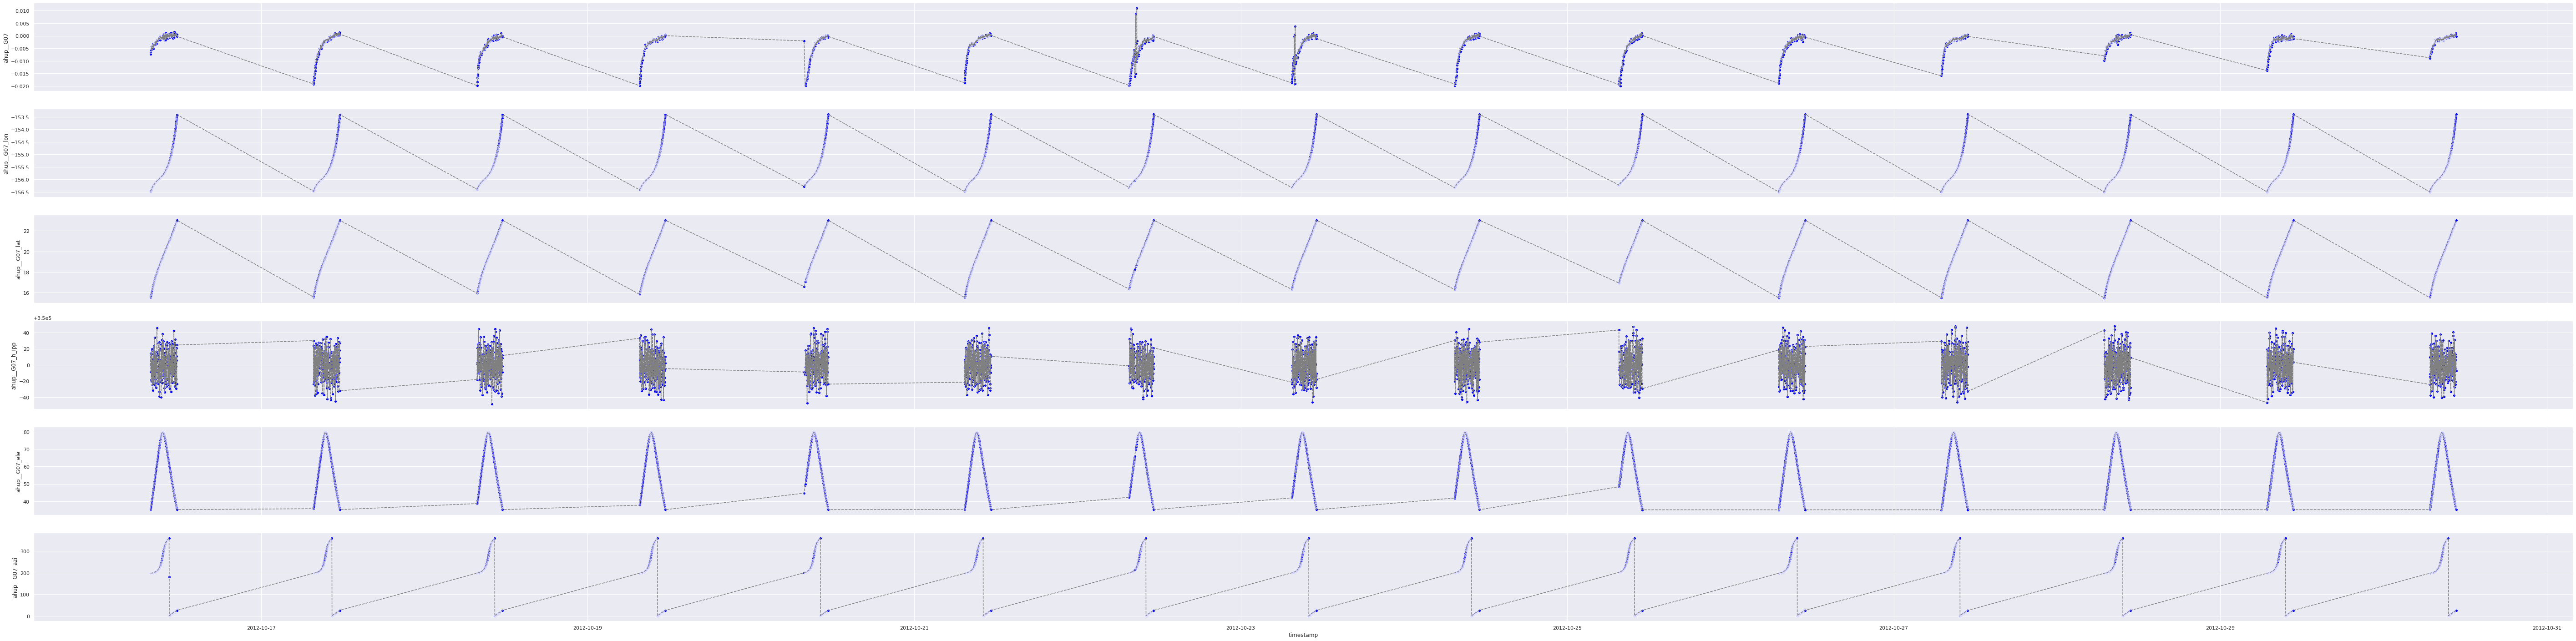

In [30]:
for d in exp.dataframes["all_days"].keys():
    
    print("\n------ " + d + " ------")
        
    plot_feature_set(exp.dataframes["all_days"][d]["merged_dataframe"])

#### On Day of Earthquake


------ ahup__G07 ------


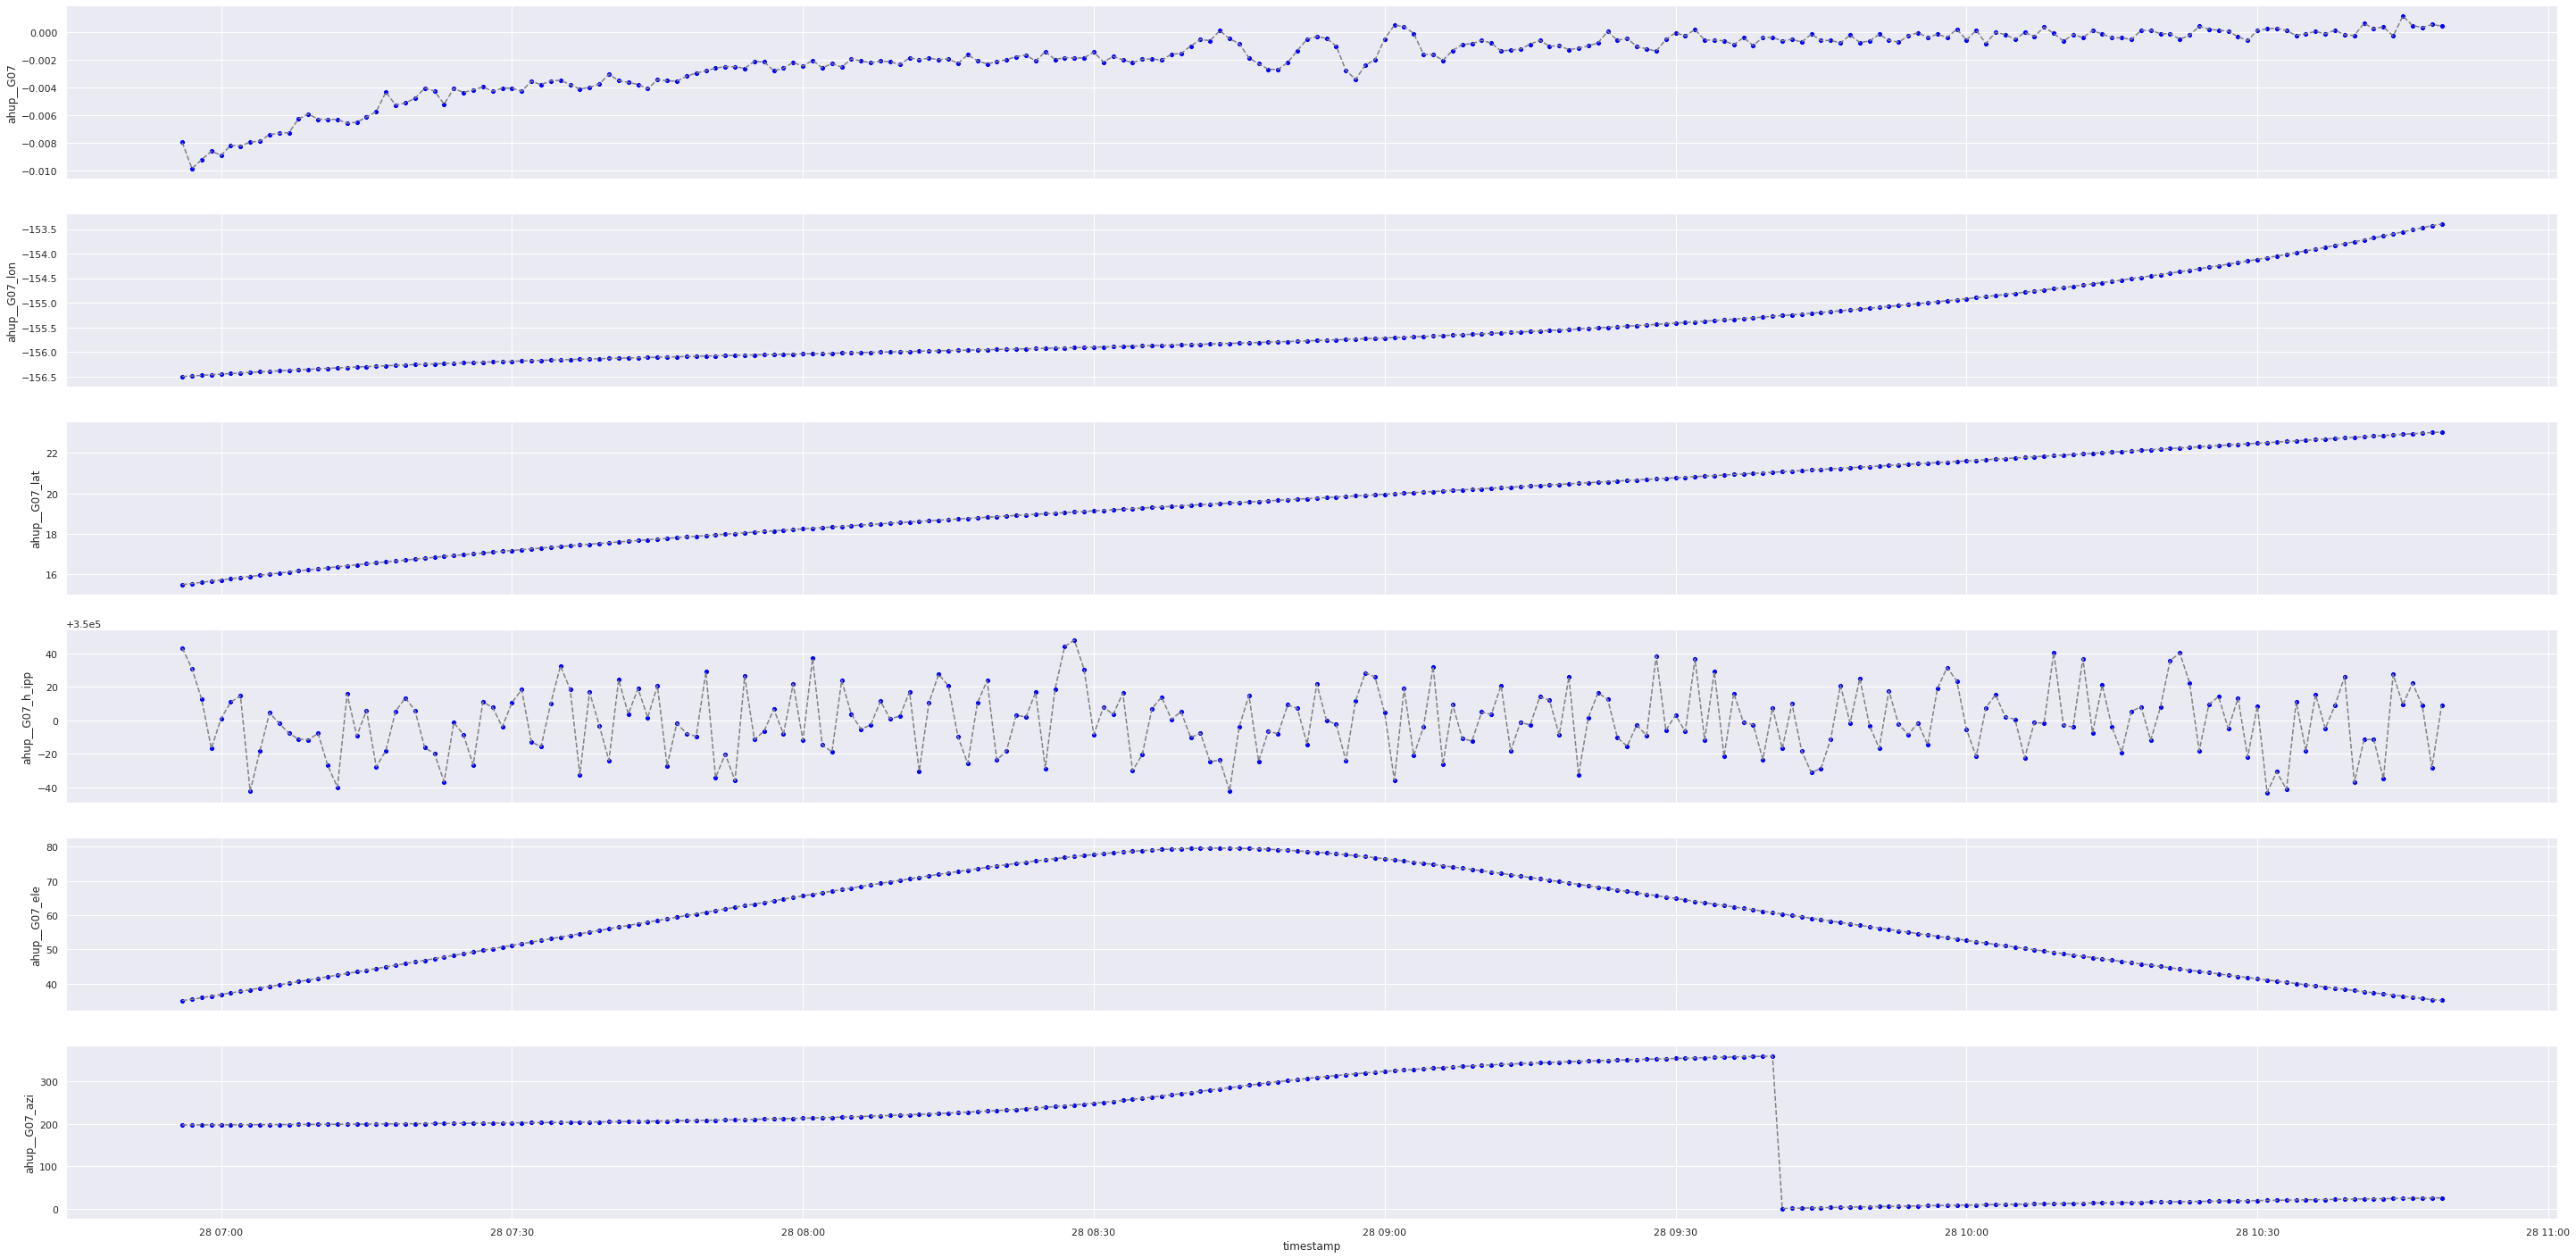

In [31]:
for d in exp.dataframes["all_days"].keys():
    
    print("\n------ " + d + " ------")
    
    # get those dates from the 28th of the month, day of the earthquake
    filter_index = exp.dataframes["all_days"][d]["merged_dataframe"].index.to_series().between('2012-10-28', '2012-10-28 23:59:00')
    
    df_sat_earthquake = exp.dataframes["all_days"][d]["merged_dataframe"][filter_index]
    
    plot_feature_set(df_sat_earthquake, figsize=(50, 25))

## Prep Data

The previous command `.merge_data()` gathered the data after being read and created dataframes for each specific satellite and ground station combination which can then be analyzed and further prepared for modeling. The `.prep_data()` function takes the data prepared in the previous step and futher prepares it for modeling, such as removing empty values from the dataset, performing concatenations, creating sliding windows, or any other steps. 

**NOTE** In future software revisions, we can tag specific data prep steps with specific models. That way, the necessary data prep steps are applied for whichever model is being passed. 

In [32]:
exp.prep_data()

In [33]:
# check that the above process was successful
# TODO: remove hard-coded ground station and satellite combination below and insert random 
# from list of passed satellites in exp 
df_test = exp.dataframes["all_days"]["ahup__G07"]["periods_allocated"]["test"]['ahup__G07']
df_test

timestamp
2012-10-27 07:00:00   -1.000000
2012-10-27 07:01:00   -0.930543
2012-10-27 07:02:00   -0.851120
2012-10-27 07:03:00   -0.766256
2012-10-27 07:04:00   -0.727248
                         ...   
2012-10-27 10:49:00    0.983553
2012-10-27 10:50:00    0.920333
2012-10-27 10:51:00    0.901501
2012-10-27 10:52:00    1.000000
2012-10-27 10:53:00    0.903519
Name: ahup__G07, Length: 234, dtype: float64

## Train the Models

We will be training a single model for each ground station and satellite combination that is contained in the Experiment object. The trained models, result sets, residual values, and other artifacts will be stored for continued analysis in the detection pipeline. 

In [34]:
# TODO: let's remove the parameterization here, as that should eventually be 
# in the Model class / object 
# this train_models function will never be exposed to the user 
# and instead will be called from exp.run()
exp.train_models(architectures[7]["layers"], architectures[7]["ps"], 16)

RuntimeError: CUDA error: out of memory

In [ ]:
#exp.predict_models()

In [ ]:
# # data 
# YEAR = 2012 # can be 2012, 2015
# LOCATION = "hawaii" # can be hawaii, chile
# DATA_PATHS = Path('../data/' + LOCATION + '/' + str(YEAR))
# DAYS = [str(f).split("/")[-1] for f in DATA_PATHS.iterdir() if f.is_dir()]
# GROUND_STATION = "ahup" # string
# SAT = "G07" # string
# ELE_FILTER = 35 # int or None
# TIME_AGG = "1Min"
# BATCH_NORM = True
# WEIGHT_DECAY = 0.1
# USE_MISSING_INDICATOR = False # create features that inform the model of missing data 

# # model specification 
# MODEL_SAVE_DIR = ""
# MODEL_NAME = "model-latest"
# if MODEL_SAVE_DIR == "":
#     MODEL_LOCATION = MODEL_NAME
# else:
#     MODEL_LOCATION = MODEL_SAVE_DIR + "/" + MODEL_NAME
# MODEL_ARCHITECTURE = 7
# BATCH_SIZE = 16
# DEP = GROUND_STATION + "__" + SAT
# FEATURES = [
# #     GROUND_STATION + "__" + SAT,
#     GROUND_STATION + "__" + SAT + "_ele",
# #     GROUND_STATION + "__" + SAT + "_lat",
# #     GROUND_STATION + "__" + SAT + "_lon",
# #     GROUND_STATION + "__" + SAT + "_h_ipp"
# ]
# MAX_EPOCHS = 500

### Time Series Cross Validation

Time-Series CV results will be tracked. Will contain the following: 

- `root_mean_square_error`
- `period`
- `learn_rate` 
- `training_time_seconds`

In [ ]:
# time_series_cv_log = list()
# cv_log_cols = ["root_mean_square_error", "period", "learn_rate", "training_time_seconds"]



# # get the current time 
# now = time.time()


# df_train[DEP + "_target"] = df_train[DEP]
# df_test = df_model_by_period["test"]
# df_test[DEP + "_target"] = df_test[DEP]
# df_valid = df_model_by_period["valid"]
# df_valid[DEP + "_target"] = df_valid[DEP]

# data_bunch = make_dataBunch(
#     df_train, 
#     df_test,
#     df_valid,
#     FEATURES, 
#     DEP + "_target", 
#     include_catvars=False, 
#     catvars=None, 
#     batch_size=BATCH_SIZE
# )

# # define the model 
# if lr is None: 
#     lr = tabular_learner(
#         data_bunch["databunch"], 
#         layers=architectures[MODEL_ARCHITECTURE]["layers"], 
#         ps=architectures[MODEL_ARCHITECTURE]["ps"],
#         metrics=[root_mean_squared_error], 
#         callback_fns=[CSVLogger, PeakMemMetric],
#         use_bn=BATCH_NORM,
#         wd=WEIGHT_DECAY
#     )

# #     # automatically find the ideal learning rate 
# #     try:
# #         learn_rate = find_appropriate_lr(
# #             model=lr,
# #             plot=True
# #         )

# #     except:
# #         learn_rate = 0.001
# #         print("ERROR: cannot determine learning rate.")

# # learn_rate = learning_rates[i]
# learn_rate = 0.0001

# print("Learning rate: " + str(learn_rate))

# # train the model 
# lr.fit_one_cycle(
#     MAX_EPOCHS, # max epochs
#     learn_rate,
#     callbacks=[
#         SaveModelCallback(
#             lr, 
#             every='epoch', 
#             monitor=['accuracy', 'root_mean_square_error']
#         ),
#         EarlyStoppingCallback(
#             lr,
#             monitor='valid_loss', #'valid_loss', 'root_mean_square_error'
#             min_delta=0.0001, # 0.0001
#             patience=15
#         ),
#         ShowGraph(
#             lr
#         )
#     ]
# )

# # loaded learners do not have a recorder
# lr.recorder.plot_losses()
# lr.recorder.plot_metrics()

# # last set of scores for this training cycle 
# rmse = lr.recorder.metrics[-1][0].item()

# # get the end time 
# later = time.time()

# # get time time difference in seconds
# time_diff = int(later - now)

# time_series_cv_log.append(
# #     [rmse, i, learn_rate, time_diff]
#     [rmse, 0, learn_rate, time_diff]
# )

# # save learner and export the model weights
# lr.save(MODEL_LOCATION)
# lr.export(MODEL_LOCATION + '-export.pkl')
    
# #     # destroy the learner and clear the mem cache 
# #     lr.destroy()
# #     torch.cuda.empty_cache() 
        
# print("Results from last training set.")
# print(lr.show_results())
   
# time_series_cv_results_df = pd.DataFrame(
#     time_series_cv_log,
#     columns=cv_log_cols
# )               

In [ ]:
# destroy the learner and clear the mem cache
# lr.destroy()
# torch.cuda.empty_cache() 

In [ ]:
# time_series_cv_results_df
# # TODO: add num epochs trained 
# # TODO: add total training time for period 

Note that the above training process is specific to a satellite and ground station. In order to report many of the metrics below, we will need to (at a later date) perform the training and testing process over multiple satellite and ground station combinations. 

Now that the model training is complete, load the learner from disk. 

In [ ]:
# lr = tabular_learner(
#         data_bunch["databunch"], 
#         layers=architectures[MODEL_ARCHITECTURE]["layers"], 
#         ps=architectures[MODEL_ARCHITECTURE]["ps"],
#         metrics=[root_mean_squared_error], 
#         callback_fns=[CSVLogger, PeakMemMetric],
#         use_bn=BATCH_NORM,
#         wd=WEIGHT_DECAY
#     )

In [ ]:
# # load learner
# lr = lr.load('model-latest') 

In [ ]:
# TODO: add this when verbose experiment is set 
lr.show_results()

Plot the values on the testing set used for model training. 

In [ ]:
# # function to predict values using input data from new data

# def predict_values(dataframe, learner, dependent, frac=1.0):
    
#     """
#     Using the passed learner, predicts the appropriate value given the input data 
#     and generates errors for analysis. 
#     """
    
#     # get a sample of the dataset 
#     dataframe_pred = dataframe.copy()
#     n_obs = int(dataframe_pred.shape[0] * frac)
#     idx = random.sample(range(0, dataframe_pred.shape[0]), n_obs)
#     dataframe_pred = dataframe_pred.iloc[idx, :]
    
#     # get the predictions
    
#     # TODO: update this to work with gpu over large samples like the other function 
#     predictions = []
#     print('Generating predictions and errors...')
#     for idx, row in tqdm(dataframe_pred.iterrows(), total=dataframe_pred.shape[0]):        
#         predictions.append(learner.predict(row)[1].numpy()[0])
    
    
#     dataframe_pred["predicted"] = predictions
#     dataframe_pred['error'] = dataframe_pred['predicted'] - dataframe_pred[dependent]
#     dataframe_pred['absolute_error'] = np.abs(dataframe_pred['error'])
#     dataframe_pred["timestamp"] = dataframe_pred.index
    
#     return dataframe_pred
    

Generate a dataframe from the predicted values on the `test` set. 

In [ ]:
df_test = predict_values(
    dataframe=data_bunch["test"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

Plot the predicted (blue) versus the actual (gray) values. 

In [ ]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_test.index, y=DEP + "_target", data=df_test, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_test.index, y=DEP + "_target",
            data=df_test,
            color="gray")


ax3 = sns.lineplot(x=df_test.index, y="predicted", data=df_test, color="blue")

plt.show()

Plot the absolute error. 

In [ ]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_test.index, y="absolute_error", data=df_test, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

In [ ]:
# simple moving average 
df_test["absolute_error_sma_3"] = df_test["absolute_error"].rolling(3, min_periods=1).mean()
df_test["absolute_error_sma_5"] = df_test["absolute_error"].rolling(5, min_periods=1).mean()
df_test["absolute_error_sma_10"] = df_test["absolute_error"].rolling(10, min_periods=1).mean()

In [ ]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_test.index, y="absolute_error", data=df_test, color="gray")
ax = sns.lineplot(x=df_test.index, y="absolute_error_sma_3", data=df_test, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

## Identify and Classify Tsunami-Related Disturbances

Using the validation data - the day of the earthquake - use the residuals to detect the anomaly. 

This section is a **work in progress**. In order to estimate the model's `accuracy`, `recall`, `precision`, `F-score`, and `coverage`, we need to be able to classify specific time periods as anomalous - in this context, as ionoshperic disturbances related to tsunami waves. 

In [ ]:
df_assess = predict_values(
    dataframe=data_bunch["valid"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

In [ ]:
df_assess.sample(frac=1).head()

### Plot Actual and Predicted Values

In [ ]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_assess.index, y=DEP + "_target", data=df_assess, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_assess.index, y=DEP + "_target",
            data=df_assess,
            color="gray")


ax3 = sns.lineplot(x=df_assess.index, y="predicted", data=df_assess, color="blue")

plt.show()

### Plot the Absolute Error 

In [ ]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess.index, y="absolute_error", data=df_assess, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

If we see a spike in the residual values at the approximate time of the tsunami-wave, we can use that information to explore ways of automating the detection of these disturbances. The approach to utilize for this classification is explored in the following sections. 

It should be noted that the ability to detect these disturbances must be thoroughly tested across multiple satellites and ground stations. 

### Plot the Smoothed Absolute Error

In [ ]:
# simple moving average 
df_assess["absolute_error_sma_3"] = df_assess["absolute_error"].rolling(3, min_periods=1).mean()
df_assess["absolute_error_sma_5"] = df_assess["absolute_error"].rolling(5, min_periods=1).mean()
df_assess["absolute_error_sma_10"] = df_assess["absolute_error"].rolling(10, min_periods=1).mean()

In [ ]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess.index, y="absolute_error", data=df_assess, color="gray")
ax = sns.lineplot(x=df_assess.index, y="absolute_error_sma_3", data=df_assess, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

### Classify Time Periods As Anomalous

Model performance will generally always be impacted towards the start of a period (day) due to having less available data (data less than the specified batch size) for making predictions. This impacts model performance (confidence) at the start of any period, and thus confidence in the model will be less at early stages (until about an hour of data is collected). 

Once the event occurs, it seems to represent a large-enough deviation from the previous day(s) (used for model training) to result in elevated absolute errors for each prediction by the model after the change begins to occur in the the TEC variation. We can use this emperical finding to create a method for detection. 

We will not be able to do any better than an on-time detection of the event (meaning, there will be some lag between the start of the event and the detection of the event). We can score the approach and generate metrics (described further below) based on some specified threshold of acceptability of detection, e.g. 5 minutes (or something else). 

In [ ]:
# definition of start times for tsunami-wave induced pertubations by satellite
# start time defined by second in day 
sod_annotations = {
    "G04": 31400,
    "G07": 31160,
    "G08": 31900,
    "G10": 29900,
    "G20": 31150
}

Let's create an improved version of an earlier plot showing absolute errors that highlights the period of increased model confidence / performance at the start of the period and also has a vertical line indicating the start time of the pertubation in TEC variation. This plot will also show the time period in which we classify as anomalous. 

In [ ]:
sod_annotations

In [ ]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="lightgray")
ax = sns.lineplot(x=df_assess["sod"], y="absolute_error_sma_3", data=df_assess, color="black")
ax.axvline(sod_annotations[SAT], color="blue", linestyle="--")
plt.text(sod_annotations[SAT] + 80, np.max(df_assess["absolute_error"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")
ax.add_patch(
    patches.Rectangle(
        (0, 0), 
        df_assess.iloc[BATCH_SIZE]["sod"],
        np.max(df_assess["absolute_error"].values),
        color="gray",
        alpha=0.3
    )
)
ax.set_title('Absolute Error - Day of Earthquake - Satellite ' + SAT)

# ax2 = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")

plt.show()

Goal to develop approach of handling residual values for detection. 

In [ ]:
# mean of abs errors 
np.mean(df_assess["absolute_error"])

In [ ]:
# standard devation
np.std(df_assess["absolute_error"])

#### Distribution of Errors 

A lot of error handling approaches and work assume that the errors have Gaussian distributions. Let's visualize the distribution of values and do a formal test for normality. If we find that the distribution of errors is generally normal, we could use approaches that are suitable for that type of data distribution. If not, we should look at other approaches for handling the model errors. 

In [ ]:
# distribution of the errors
plt.figure(figsize=(10, 10))
sns.distplot(df_assess["absolute_error"].values, kde=True, rug=True);
plt.show()

Let's plot a QQ plot. This will provide a visual indication as to the normality of the data. If the points closely follow the diagonal line, then they closely fit the pattern we would expect from a Gaussian distribution. 

In [ ]:
qq = stats.probplot(df_assess["absolute_error"].values, dist='lognorm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

fig = go.Figure()
fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
fig.layout.update(showlegend=False)
fig.show()

#### Normality Tests

In [ ]:
# Shapiro normality test
stat, p = stats.shapiro(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
# D’Agostino’s K^2  normality test
stat, p = stats.normaltest(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
# Anderson-Darling normality test
result = stats.anderson(df_assess["absolute_error"].values)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

#### Using a Time-based Distancing Approach 

For each observation, get the distances from each of the previous observations from _T_ steps prior (so the difference / distance in absolute errors). Then, log transform these distances to prioritize local anomalies (inspired from approach by Ian Colwell for MSL anomaly detection). 

In [ ]:
# number of previous time steps T to consider
DIST_WINDOW = 10

In [ ]:
def calc_dist_measure(dataframe: pd.DataFrame, window_size: int = 10, show_dist_plot: bool = False) -> pd.DataFrame:

    """
    Calculates the distance 
    """
    
    # create a dataframe for the errors 
    df_error = dataframe[["sod", "absolute_error_sma_3"]].iloc[window_size:].reset_index().sort_values(by="sod")
    
    # create a dataframe to store distances between absolute errors
    # more specifically, to store the mean distance from an observation 
    # to its previous N neighbors 
    df_error_dist = pd.DataFrame(list(), index=df_error["sod"], columns=df_error["sod"])
    for idx, row in tqdm(df_error.iterrows(), total=df_error.shape[0]):
    
        # get the current absolute error 
        abs_error = row["absolute_error_sma_3"]

        # get the absolute error values for the previous N values
        prev = dataframe.iloc[idx:idx+window_size] # note indexing to account for window size 
        
        # get the distances 
        for idx2, row2 in prev.iterrows():
            
            # TODO: could apply a weighted average here 
            
            dist = spatial.distance.euclidean(abs_error, row2["absolute_error_sma_3"])    
            # note log transformed values here :
            df_error_dist.loc[row["sod"], row2["sod"]] = np.log(dist + 1.)
#             df_error_dist.loc[row["sod"], row2["sod"]] = dist
            df_error_dist.loc[row2["sod"], row["sod"]] = np.log(dist + 1.) 
#             df_error_dist.loc[row2["sod"], row["sod"]] = dist 
            
    # optionally show a plot 
    if show_dist_plot is True:
        plt.figure(figsize=(15, 10))
        ax = sns.heatmap(df_error_dist.sort_index().sort_index(axis=1).fillna(0.))
        plt.show()
        
    # use that distance matrix to get the min/max/mean distance in the last window  
    # we only want to use observations with a full window size 
    counts = df_error_dist.count().reset_index().rename(columns={0: "counts"})
    full_sods = counts[counts["counts"] >= window_size]["sod"]
    
#     df_error_dist_flat = df_error_dist.loc[full_sods].mean(axis=1)
    df_error_dist_flat = df_error_dist.loc[full_sods].min(axis=1)
#     df_error_dist_flat = df_error_dist.loc[full_sods].max(axis=1)
    df_error_dist_flat = df_error_dist_flat.reset_index().rename(columns={0: "dist_measure"})

    return df_error_dist_flat

In [ ]:
df_test_dist_calc = calc_dist_measure(
    df_test,
    window_size=DIST_WINDOW,
    show_dist_plot=True
)

In [ ]:
df_test_dist_calc["dist_measure"].shape

In [ ]:
df_test.shape

In [ ]:
def get_val(dataframe, row):
    try:
        return dataframe[dataframe["sod"] == row]["dist_measure"].values[0]
    except:
        return 0.

In [ ]:
df_test["dist_measure"] = [0.] * df_test.shape[0]
df_test["dist_measure"] = df_test["sod"].apply(
    lambda x: get_val(df_test_dist_calc, x)
)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_test["dist_measure_scaled"] = scaler.fit_transform([df_test["dist_measure"].values]).T

# df_test["dist_measure"]

In [ ]:
sns.distplot(df_test["dist_measure"].values, kde=True, rug=True);

In [ ]:
df_test["dist_measure"].describe()

In [ ]:
m_test = loop.LocalOutlierProbability(
    df_test.iloc[BATCH_SIZE:]["absolute_error"].values, 
    extent=3, 
    n_neighbors=30
).fit()
m_test_scores = m_test.local_outlier_probabilities
df_test["loop_scores"] = list([0.] * BATCH_SIZE) + list(m_test_scores)

In [ ]:
VMAX = 0.01

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(40, 10))
grid = plt.GridSpec(4, 8, wspace=0.4, hspace=0.3)

plt.subplot(grid[1:3, 0:8])

# ax1 = plt.figure(figsize=(30, 10))
ax1 = sns.lineplot(x=df_test["sod"], y="absolute_error", data=df_test, color="black")
ax1.margins(x=0)

# add a vertical line to indicate when a full window of distance values is available 
ax1.axvline(df_test.iloc[DIST_WINDOW]["sod"], color="purple", linestyle="--")
ax1.text(df_test.iloc[DIST_WINDOW]["sod"] + 80, np.max(df_assess["absolute_error"].values) / 2, "Window Buffer", rotation=90, verticalalignment='center', color="purple")

plt.subplot(grid[0, 0:8])
ax2 = sns.heatmap(
    [df_test["dist_measure"].values],
    cmap="bwr",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    vmin=0, 
    vmax=VMAX
)


plt.show()

In [ ]:
df_assess_dist_calc = calc_dist_measure(
    df_assess,
    window_size=DIST_WINDOW,
    show_dist_plot=False
)

In [ ]:
df_assess["dist_measure"] = [0.] * df_assess.shape[0]
df_assess["dist_measure"] = df_assess["sod"].apply(
    lambda x: get_val(df_assess_dist_calc, x)
)

In [ ]:
sns.distplot(df_assess["dist_measure"].values, kde=True, rug=True);

In [ ]:
df_assess["dist_measure"].describe()

In [ ]:
df_assess.shape

In [ ]:
m_assess = loop.LocalOutlierProbability(
    df_assess.iloc[BATCH_SIZE:]["absolute_error"].values, 
    extent=3, 
    n_neighbors=30
).fit()
m_assess_scores = m_assess.local_outlier_probabilities
df_assess["loop_scores"] = list([0.] * BATCH_SIZE) + list(m_assess_scores)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(40, 10))
grid = plt.GridSpec(4, 8, wspace=0.4, hspace=0.3)

plt.subplot(grid[1:3, 0:8])

# ax1 = plt.figure(figsize=(30, 10))
ax1 = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")
ax1.margins(x=0)

# add a vertical line to indicate the event 
ax1.axvline(sod_annotations[SAT], color="blue", linestyle="--")
ax1.text(sod_annotations[SAT] + 80, np.max(df_assess["absolute_error"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")

# add a vertical line to indicate when a full window of distance values is available 
ax1.axvline(df_assess.iloc[DIST_WINDOW]["sod"], color="purple", linestyle="--")
ax1.text(df_assess.iloc[DIST_WINDOW]["sod"] + 80, np.max(df_assess["absolute_error"].values) / 2, "Window Buffer", rotation=90, verticalalignment='center', color="purple")


plt.subplot(grid[0, 0:8])
ax2 = sns.heatmap(
    [df_assess["dist_measure"].values],
    cmap="bwr",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    vmin=0, 
    vmax=VMAX
)

plt.show()

## Metrics

We need to report the following metrics: 

- **Root Mean Square Error**: measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed
- **Accuracy**: the number of correct classifications over the number of observations
- **Recall**: fraction of true events that were detected
- **Precision**: fraction of detections reported  by the model that are correct
- **F-Score**: the harmonic mean of the precision and recall, `2pr / (p + r)`
- **Coverage**: fraction of examples for which the system is able to produce a confident classification

In [ ]:
# pickle and store the entire experiment object (which can later be loaded and re-examined)